In [64]:
# Librerías esenciales para procesamiento de audio y visualización
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm  # Progreso opcional

# Ruta base del dataset
base_path = '/kaggle/input/depression-dataset/dataset-depression'

# Nombres de las carpetas por categoría
categories = ['depression1', 'depression2', 'normal1', 'normal2']

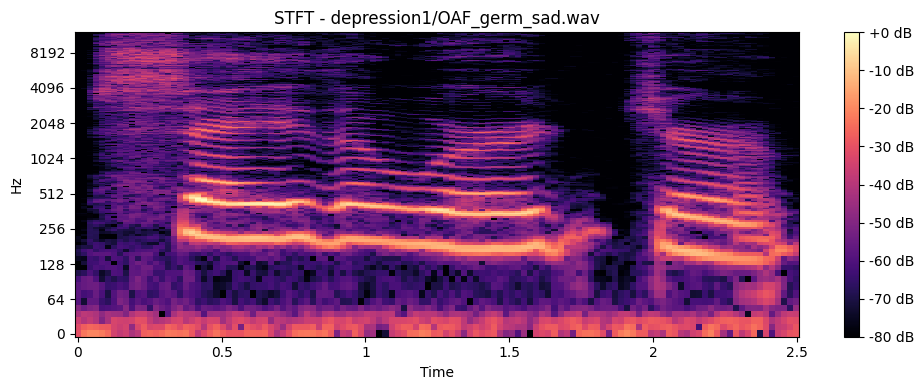

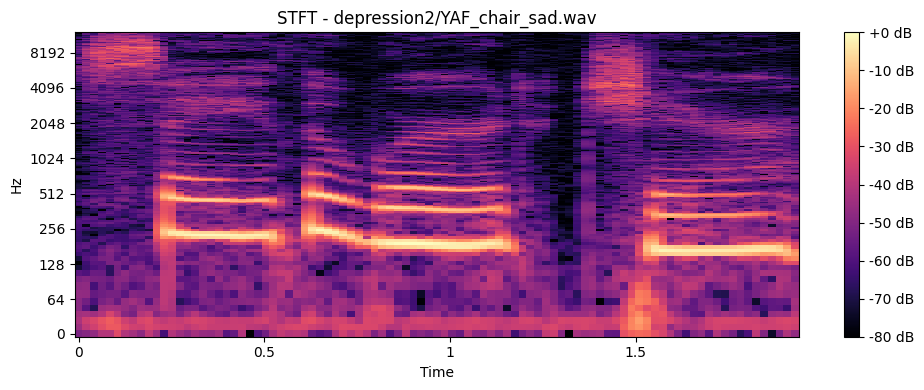

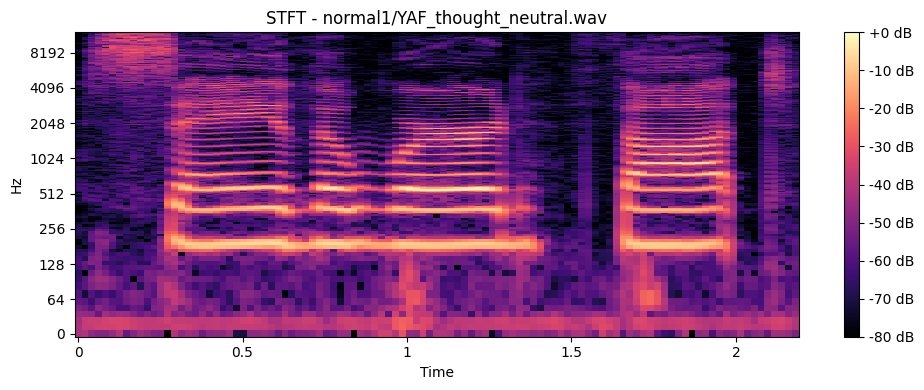

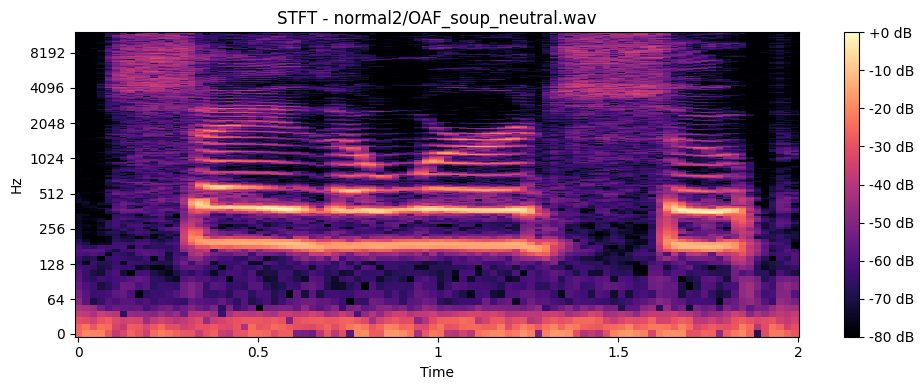

In [10]:
# Lista para almacenar resultados STFT
stft_data = []

# Solo un ejemplo por carpeta para prueba visual
for category in categories:
    category_path = os.path.join(base_path, category)
    for i, filename in enumerate(os.listdir(category_path)):
        if filename.endswith('.wav'):
            file_path = os.path.join(category_path, filename)
            
            # Cargar audio
            y, sr = librosa.load(file_path, sr=None)
            
            # STFT
            stft_result = librosa.stft(y)
            stft_magnitude, _ = librosa.magphase(stft_result)
            stft_db = librosa.amplitude_to_db(stft_magnitude, ref=np.max)
            
            # Guardar
            stft_data.append(stft_db)
            
            # Mostrar visualmente el primero
            if i == 0:
                plt.figure(figsize=(10, 4))
                librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='log')
                plt.colorbar(format='%+2.0f dB')
                plt.title(f'STFT - {category}/{filename}')
                plt.tight_layout()
                plt.show()
        break

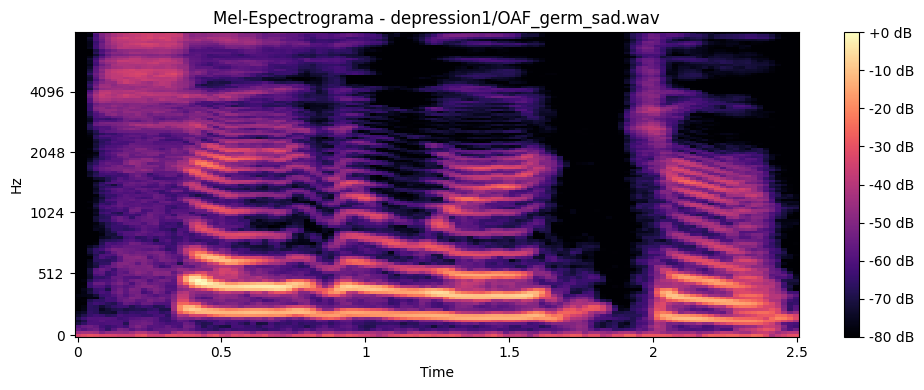

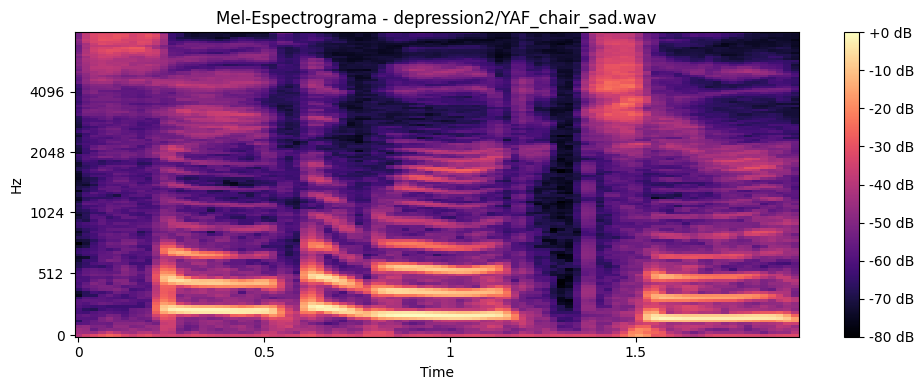

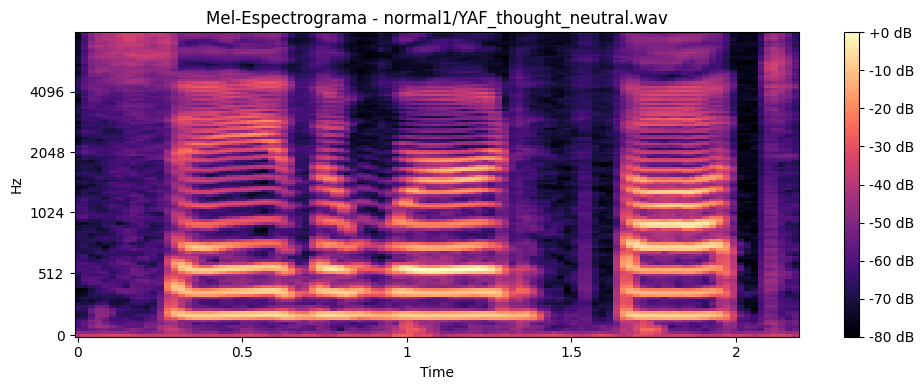

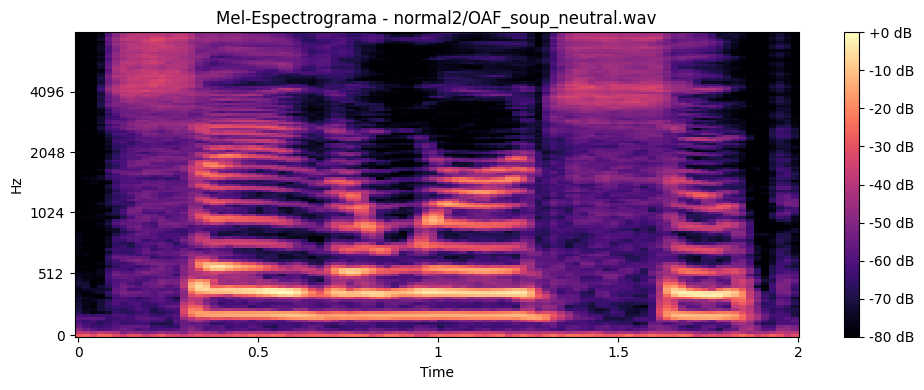

In [4]:
mel_data = []

# Mel-Espectrograma
for category in categories:
    category_path = os.path.join(base_path, category)
    for i, filename in enumerate(os.listdir(category_path)):
        if filename.endswith('.wav'):
            file_path = os.path.join(category_path, filename)
            
            # Cargar audio
            y, sr = librosa.load(file_path, sr=None)
            
            # Calcular mel-espectrograma
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            
            # Guardar
            mel_data.append(mel_spec_db)
            
            if i == 0:
                plt.figure(figsize=(10, 4))
                librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
                plt.colorbar(format='%+2.0f dB')
                plt.title(f'Mel-Espectrograma - {category}/{filename}')
                plt.tight_layout()
                plt.show()
        break

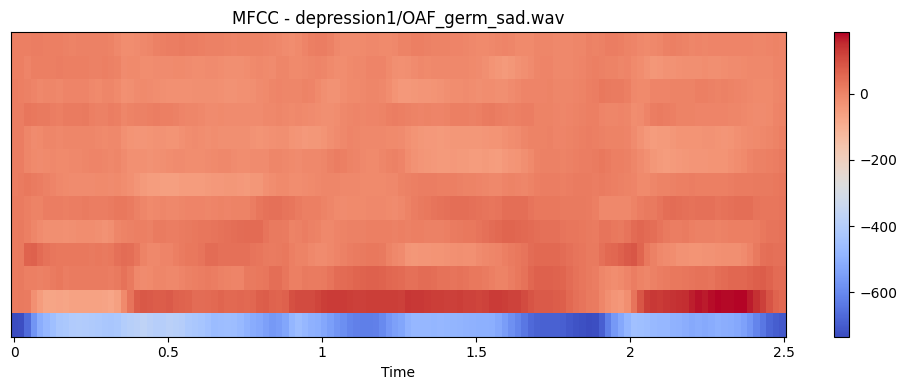

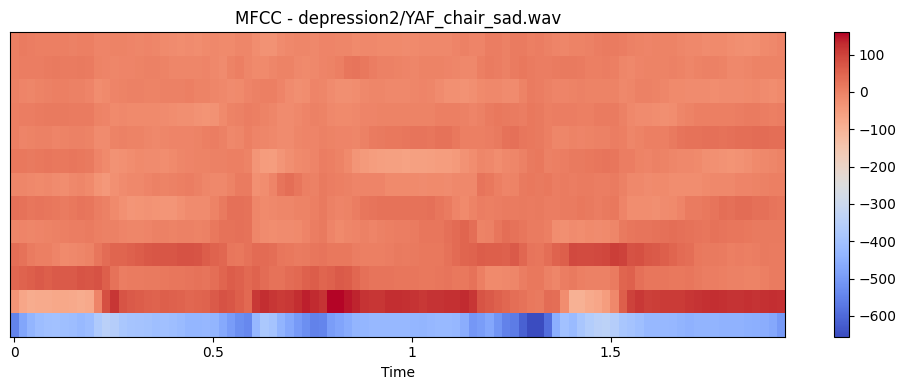

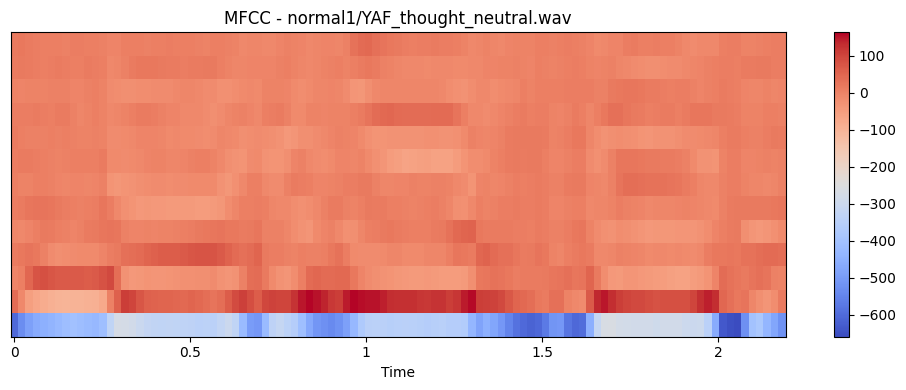

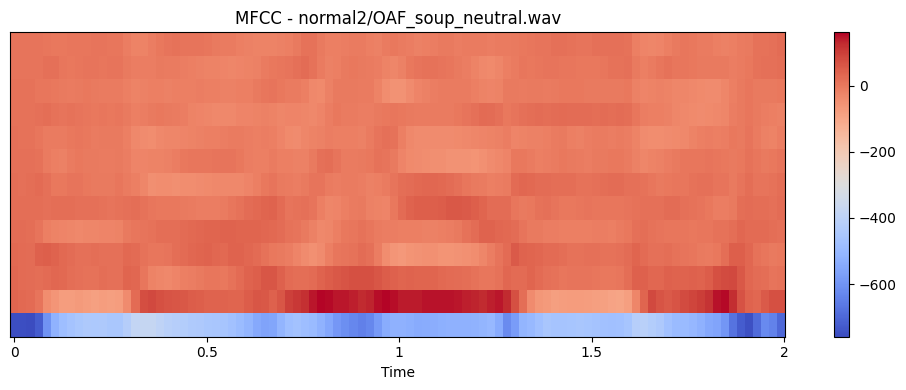

In [7]:
mfcc_data = []

# MFCC
for category in categories:
    category_path = os.path.join(base_path, category)
    for i, filename in enumerate(os.listdir(category_path)):
        if filename.endswith('.wav'):
            file_path = os.path.join(category_path, filename)
            
            # Cargar audio
            y, sr = librosa.load(file_path, sr=None)
            
            # Calcular MFCCs
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            mfcc_data.append(mfcc)
            
            # Mostrar ejemplo visual del primero
            if i == 0:
                plt.figure(figsize=(10, 4))
                librosa.display.specshow(mfcc, x_axis='time', sr=sr)
                plt.colorbar()
                plt.title(f'MFCC - {category}/{filename}')
                plt.tight_layout()
                plt.show()
        break

In [56]:
# Parámetros
n_mels = 128
fixed_size = (n_mels, n_mels)

# Estructuras para almacenar resultados
X = []
y = []

# Mapeo de etiquetas
label_map = {'depression1': 1, 'depression2': 1, 'normal1': 0, 'normal2': 0}

# Procesamiento
for category in categories:
    cat_path = os.path.join(base_path, category)
    label = label_map[category]
    
    for fname in tqdm(os.listdir(cat_path), desc=f"Procesando {category}"):
        if fname.endswith('.wav'):
            file_path = os.path.join(cat_path, fname)
            audio, sr = librosa.load(file_path, sr=None)
            melspec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, fmax=8000)
            melspec_db = librosa.power_to_db(melspec, ref=np.max)

            # Redimensionar y normalizar
            melspec_resized = np.resize(melspec_db, fixed_size)
            melspec_norm = (melspec_resized - melspec_resized.min()) / (melspec_resized.max() - melspec_resized.min() + 1e-6)

            X.append(melspec_norm)
            y.append(label)

# Convertir a arrays NumPy
X = np.array(X)[..., np.newaxis]  # Añade canal (como imagen)
y = np.array(y)

print("✔️ Datos procesados. Formas finales:")
print("X:", X.shape)
print("y:", y.shape)

Procesando normal2: 100%|██████████| 200/200 [00:01<00:00, 117.07it/s]

✔️ Datos procesados. Formas finales:
X: (800, 128, 128, 1)
y: (800,)


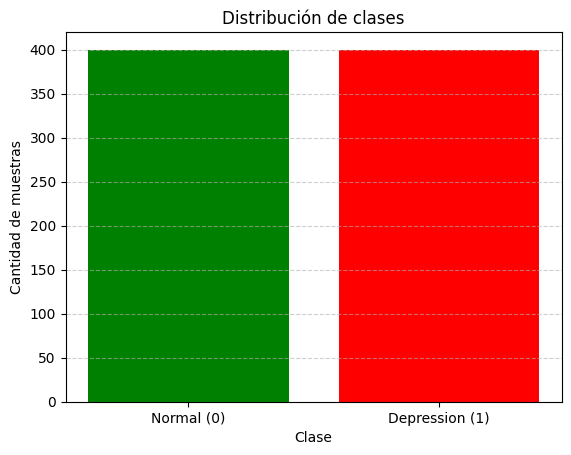

In [15]:
labels, counts = np.unique(y, return_counts=True)
plt.bar(['Normal (0)', 'Depression (1)'], counts, color=['green', 'red'])
plt.title("Distribución de clases")
plt.xlabel("Clase")
plt.ylabel("Cantidad de muestras")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

# **Fase 4: Modelado y Experimentación**
En esta fase se implementan y comparan diferentes modelos de aprendizaje automático y redes neuronales con el fin de clasificar correctamente las muestras de audio procesadas (espectrogramas) en dos clases: normal (0) y depresión (1).

***CNN – Parte 1: Carga de datos***

In [16]:
np.save("X_melspec.npy", X)
np.save("y_labels.npy", y)
print("✅ Archivos guardados: X_melspec.npy y y_labels.npy")

✅ Archivos guardados: X_melspec.npy y y_labels.npy


In [17]:
# Cargar datos procesados
X = np.load("X_melspec.npy")
y = np.load("y_labels.npy")

print("✔️ Datos cargados correctamente")
print("X:", X.shape)
print("y:", y.shape)

✔️ Datos cargados correctamente
X: (800, 128, 128, 1)
y: (800,)


***CNN – Parte 2: División en entrenamiento y prueba***

In [13]:
from sklearn.model_selection import train_test_split

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✔️ División completada")
print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

✔️ División completada
Train: (640, 128, 128, 1) (640,)
Test: (160, 128, 128, 1) (160,)


***CNN – Parte 3: Construcción del modelo CNN básico***

In [55]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Definir arquitectura CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2,2)),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Salida binaria: normal(0) o depresión(1)
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,391,873 (28.20 MB)

 Trainable params: 7,391,873 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

***CNN – Parte 4: Entrenamiento del modelo***

In [30]:
# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.5483 - loss: 1.1604 - val_accuracy: 0.9062 - val_loss: 0.4655
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8827 - loss: 0.4005 - val_accuracy: 0.9609 - val_loss: 0.2096
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9416 - loss: 0.1805 - val_accuracy: 0.9688 - val_loss: 0.1194
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9748 - loss: 0.0974 - val_accuracy: 0.9766 - val_loss: 0.0738
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9891 - loss: 0.0375 - val_accuracy: 0.9766 - val_loss: 0.0551
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9998 - loss: 0.0157 - val_accuracy: 0.9922 - val_loss: 0.0361
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9970 - loss: 0.0127 - val_accuracy: 0.9844 - val_loss: 0.0377
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9979 - loss: 0.0119 - val_accuracy: 0.9844 - v

***CNN – Parte 6: Visualización del entrenamiento***

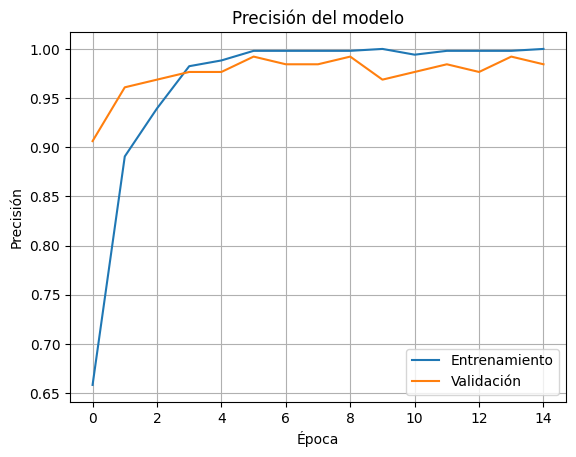

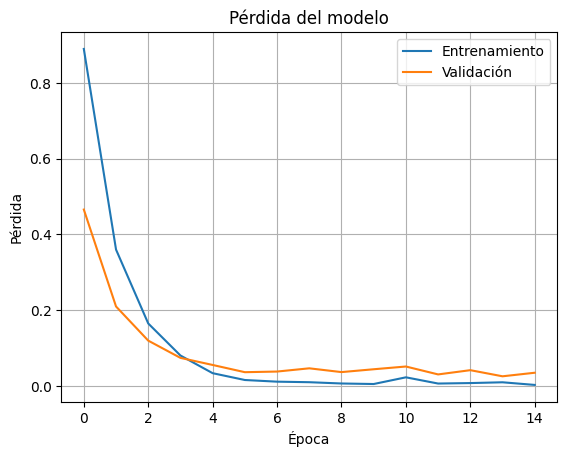

In [31]:
import matplotlib.pyplot as plt

# Precisión
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()

# Pérdida
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

***MLP (Multilayer Perceptron) Parte 1: Carga de datos***

In [18]:
# Cargar los datos
X = np.load("X_melspec.npy")
y = np.load("y_labels.npy")

# Aplanar imágenes (128x128x1 → 16384)
X_flat = X.reshape(X.shape[0], -1)

print("Shape de X_flat:", X_flat.shape)
print("Shape de y:", y.shape)

Shape de X_flat: (800, 16384)
Shape de y: (800,)


***MLP (Multilayer Perceptron) Parte 2: Definición del modelo***

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Modelo MLP
mlp_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_flat.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compilar
mlp_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

mlp_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,227,585 (16.13 MB)

 Trainable params: 4,227,585 (16.13 MB)

 Non-trainable params: 0 (0.00 B)

***MLP (Multilayer Perceptron) Parte 3: Entrenamiento del modelo***

In [20]:
# Entrenamiento
history_mlp = mlp_model.fit(X_flat, y,
                            epochs=15,
                            batch_size=32,
                            validation_split=0.2,
                            verbose=1)

Epoch 1/15


I0000 00:00:1749600869.583349     101 service.cc:148] XLA service 0x7f17300057c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749600869.584114     101 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749600869.584142     101 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749600869.857734     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6179 - loss: 2.2301 

I0000 00:00:1749600871.581150     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6275 - loss: 2.0719 - val_accuracy: 0.6562 - val_loss: 0.8215
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8335 - loss: 0.5198 - val_accuracy: 0.8125 - val_loss: 0.4869
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8889 - loss: 0.2814 - val_accuracy: 0.9625 - val_loss: 0.1118
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9417 - loss: 0.1944 - val_accuracy: 0.9438 - val_loss: 0.1665
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9767 - loss: 0.0810 - val_accuracy: 0.9375 - val_loss: 0.1755
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9824 - loss: 0.0662 - val_accuracy: 0.9625 - val_loss: 0.0841
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9852 - loss: 0.0369 - val_accuracy: 0.9438 - val_loss: 0.1428
Epoch 8/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9920 - loss: 0.0337 - val_accuracy: 0.8438 - val_loss: 0.4035
Ep

***MLP (Multilayer Perceptron) Parte 4: Evaluación y visualización***

🔍 Precisión del MLP: 0.9975


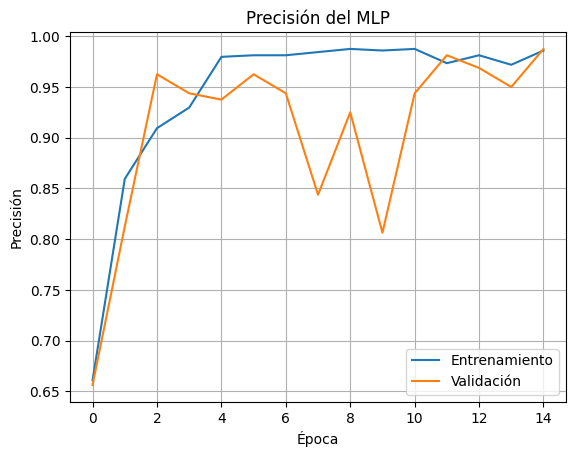

In [21]:
# Evaluación
loss, acc = mlp_model.evaluate(X_flat, y, verbose=0)
print(f"🔍 Precisión del MLP: {acc:.4f}")

# Curvas de entrenamiento
plt.plot(history_mlp.history['accuracy'], label='Entrenamiento')
plt.plot(history_mlp.history['val_accuracy'], label='Validación')
plt.title('Precisión del MLP')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()

***Preparar los datos para LSTM/GRU***

In [32]:
# Cambiar forma del input: (128, 128, 1) → (128, 128)
X_seq_lstm = X.reshape(-1, 128, 128)

# Dividir en entrenamiento y prueba
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_seq_lstm, y, test_size=0.2, random_state=42)

print(f"✔️ Shape entrenamiento: {X_train_lstm.shape}, etiquetas: {y_train_lstm.shape}")
print(f"✔️ Shape prueba:        {X_test_lstm.shape}, etiquetas: {y_test_lstm.shape}")


✔️ Shape entrenamiento: (640, 128, 128), etiquetas: (640,)
✔️ Shape prueba:        (160, 128, 128), etiquetas: (160,)


***Construcción del modelo LSTM***

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(64, return_sequences=True, input_shape=(128, 128)))
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))

# Compilar
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,001 (250.00 KB)

 Trainable params: 64,001 (250.00 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
print("Shape de X_flat:", X_flat.shape)
print("Shape de y:", y.shape)

Shape de X_flat: (800, 16384)
Shape de y: (800,)


***Entrenamiento del modelo LSTM***

In [34]:
# Entrenar
history_lstm = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=10,
    batch_size=32
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.4863 - loss: 0.7028 - val_accuracy: 0.5063 - val_loss: 0.6649
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7161 - loss: 0.6307 - val_accuracy: 0.8625 - val_loss: 0.4373
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8439 - loss: 0.4346 - val_accuracy: 0.7875 - val_loss: 0.4413
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8098 - loss: 0.4226 - val_accuracy: 0.8375 - val_loss: 0.3422
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8820 - loss: 0.3203 - val_accuracy: 0.8875 - val_loss: 0.2552
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8913 - loss: 0.2860 - val_accuracy: 0.8875 - val_loss: 0.2900
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8414 - loss: 0.3807 - val_accuracy: 0.9062 - val_loss: 0.2169
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9142 - loss: 0.2386 - val_accuracy: 0.9438 - v

In [27]:
# Cambiar la forma de entrada de (128, 128, 1) a (128, 128)
X_seq = X.reshape(-1, 128, 128)  # [n_samples, time_steps, features]

# Dividir en entrenamiento y prueba
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y, test_size=0.2, random_state=42)

print(f"✔️ Shape entrenamiento: {X_train_seq.shape}, etiquetas: {y_train_seq.shape}")
print(f"✔️ Shape prueba:        {X_test_seq.shape}, etiquetas: {y_test_seq.shape}")

✔️ Shape entrenamiento: (640, 128, 128), etiquetas: (640,)
✔️ Shape prueba:        (160, 128, 128), etiquetas: (160,)


In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Atención multi-cabeza
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feedforward
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

# Entrada del modelo
input_layer = layers.Input(shape=(128, 128))

# Codificador Transformer
x = transformer_encoder(input_layer, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

# Modelo final
transformer_model = models.Model(inputs=input_layer, outputs=output_layer)
transformer_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

transformer_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 128, 128)       │        131,968 │ input_layer_3[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 128, 128)       │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 128, 128)       │            256 │ dropout_6[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 128)       │              0 │ layer_normalization[0… │
│                           │                        │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 128, 128)       │         16,512 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 128, 128)       │              0 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 128, 128)       │         16,512 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 128, 128)       │            256 │ conv1d_1[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 128, 128)       │              0 │ layer_normalization_1… │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 128)            │              0 │ add_1[0][0]            │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 128)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 64)             │          8,256 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 64)             │              0 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 1)              │             65 │ dropout_9[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 173,825 (679.00 KB)

 Trainable params: 173,825 (679.00 KB)

 Non-trainable params: 0 (0.00 B)

# **Entrenamiento del modelo Transformer**

In [29]:
# Entrenamiento
history_transformer = transformer_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=10,
    batch_size=32
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.5172 - loss: 1.1846 - val_accuracy: 0.5000 - val_loss: 0.7706
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5197 - loss: 0.7424 - val_accuracy: 0.5000 - val_loss: 0.7929
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5903 - loss: 0.6916 - val_accuracy: 0.5125 - val_loss: 0.6775
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5020 - loss: 0.7045 - val_accuracy: 0.7188 - val_loss: 0.6699
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5795 - loss: 0.6779 - val_accuracy: 0.5188 - val_loss: 0.6651
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5044 - loss: 0.7039 - val_accuracy: 0.5688 - val_loss: 0.6605
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6266 - loss: 0.6635 - val_accuracy: 0.7688 - val_loss: 0.6179
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6575 - loss: 0.6308 - val_accuracy: 0.7188 - 

# **FASE 5: MODELOS DE EVALUACION**

In [65]:
from sklearn.model_selection import train_test_split

# Carga los datos desde los archivos .npy (si aún no los tienes en memoria)
X = np.load("X_melspec.npy")
y = np.load("y_labels.npy")

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

***Evaluando el modelo MLP***

In [66]:
# Predecir usando el modelo CNN
y_pred_cnn = cnn_model.predict(X_test)

# Convertir las probabilidades a clases (0 o 1)
y_pred_cnn = (y_pred_cnn > 0.5).astype(int).flatten()

NameError: name 'cnn_model' is not defined

In [67]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_cnn)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Depresión'], 
            yticklabels=['Normal', 'Depresión'])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión – CNN")
plt.show()

# Reporte de métricas
print("📊 Reporte de Clasificación – CNN")
print(classification_report(y_test, y_pred_cnn))

NameError: name 'y_pred_cnn' is not defined

In [68]:
from sklearn.metrics import roc_curve, roc_auc_score

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_cnn)
roc_auc = roc_auc_score(y_test, y_pred_cnn)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC – CNN")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'y_pred_cnn' is not defined

In [69]:
from sklearn.metrics import precision_recall_curve, auc

# Curva de Precisión-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_cnn)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.2f}", color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precisión-Recall – CNN")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'y_pred_cnn' is not defined